In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.326726  0.005213  0.113758 -0.429714 -0.224439 -0.840023 -1.727005   
  1   0.224260 -0.403522  1.150744  0.653036  1.578374  0.109492 -0.668159   
  2  -1.482315 -0.094012  0.224983  0.292975  0.273911 -0.108304 -0.344889   
  3  -0.722981  0.070104  0.423342  0.706693  0.441596 -1.060026 -0.574465   
  4   0.568841  1.062635  0.454494  1.433643  0.880225  0.812865  0.597249   
  5  -0.793579 -1.008214  0.570925  1.292596  0.608262  0.936583  1.737575   
  6   0.265090  0.613499  0.494573 -0.008803  0.093705 -0.686525 -0.616848   
  7   0.014007  0.488354  0.903162  0.422584  0.756989 -0.279656 -1.093386   
  8  -0.418880 -0.143380  0.265038  0.782890  0.296040  0.299297  1.156577   
  9   0.389263 -0.637526  0.976265  0.117150  0.318549  0.532552 -0.886245   
  10  0.074506  0.044972 -0.903987 -0.582031  0.349183  0.608598  0.488369   
  11 -0.327768 -0.998475 -0.053072  0.247133  1.473400  0.439140  0.365080   
  12  0.110276 -0.555432 -0.097125  0.174326  1.391321  0.008283 -0.699677   
  13 -0.981887  0.431649  0.362793  0.747474  0.520853  0.581740 -0.080677   
  14  0.320989 -0.517115  0.644370  0.483846  0.206545 -0.431695 -0.269708   
  15  1.119277  0.117874  0.682956  0.599816 -0.259667  0.509293 -0.659650   
  16  0.875782 -0.842722  0.964107  0.515264  1.030887  1.117340  0.908043   
  17 -0.420366 -0.472217  0.297100 -0.539460  0.253231 -0.236892  0.082624   
  18  0.396108  0.425193  0.033717  0.700222  0.801113  0.030472 -0.398997   
  19  0.017606  0.070062  0.827404 -0.195470  0.029834  0.209949  0.510000   
  20  0.887266 -0.531276  0.609786  0.600628  0.748357 -0.013054 -0.516292   
  21 -0.224668 -0.327591 -0.194068 -0.030029  0.291067  0.408809 -0.224817   
  22  0.594636  0.163004  0.148079 -0.435458  0.278409 -0.946838  0.402913   
  23  0.302185 -1.177060 -0.602812  0.614738  0.820630  0.996897  0.212690   
  24  0.063217  0.646391  0.725719  1.246063  1.563566  0.251307  0.459645   
1 0  -0.013331 -0.900011  0.095811  0.259688  0.834970 -0.552261 -0.130468   
  1  -0.315412 -1.048966 -0.321403  0.402788 -0.030796  0.075883  0.039585   
  2  -0.311988  0.135271 -0.103463 -1.228168 -1.263791 -0.635734 -0.549919   
  3  -0.489056  0.583740 -0.321394  0.344536  0.143953  0.865060  0.251702   
  4  -1.232384 -0.357996 -0.191872  0.066104  0.732777 -0.030174 -0.205184   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.674796 -0.611114 -0.704275  ...  1.862426  1.345481 -0.403954   
  1   0.404031 -0.805457 -0.058949  ... -0.036164 -0.562180  0.997478   
  2  -0.147357  0.391559  0.579440  ...  0.820988 -0.136714  0.121204   
  3  -0.091690  0.461891  1.492776  ...  0.649788  0.239447  0.175442   
  4   0.274293 -0.686446  1.391738  ... -0.422395  0.013598 -0.473491   
  5   0.309316  0.806139  1.577492  ...  0.524534 -0.367163  1.175969   
  6   0.244203  0.174086  0.318652  ...  0.209618  0.159074 -0.414632   
  7  -0.079872 -0.315543  0.980622  ...  0.617281 -0.238515 -0.477961   
  8   0.010069  0.352137  0.577929  ...  1.431586  0.356126  0.489024   
  9   0.008605  0.365746  0.025053  ...  0.711167  0.535176  0.217867   
  10  1.276845  0.271042  0.316296  ...  0.779193  0.051407 -0.314519   
  11 -1.231260 -0.065289  0.970562  ...  0.078896 -0.122276  0.115573   
  12 -0.395250 -0.850051 -1.492732  ...  1.311996 -0.097116  0.509345   
  13  0.967049  0.401482 -0.213565  ... -0.466911 -1.052994  0.285066   
  14  0.183933  0.288916  0.050525  ...  0.936469  0.248410 -0.428297   
  15 -0.738605  0.030407  0.922392  ...  0.633972  0.298418  0.472404   
  16 -0.217863 -0.519579  0.844156  ...  1.535122  0.044625  0.564784   
  17  0.332879 -0.305310  0.365855  ...  1.608578  0.432699 -0.363392   
  18 -0.036009  0.892367  1.313154  ...  1.215707 -0.211727  0.035486   
  19 -0.227412  0.476630  0.578241  ...  0.544148  0.180711  0.765472   
  20  0.628291  0.055883  0.126506  ...  0.919908  0.273666 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef  std err          t          P>|t|     2.5 %    97.5 %
D  1.006907  0.04052  24.849529  2.616353e-136  0.927489  1.086325


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



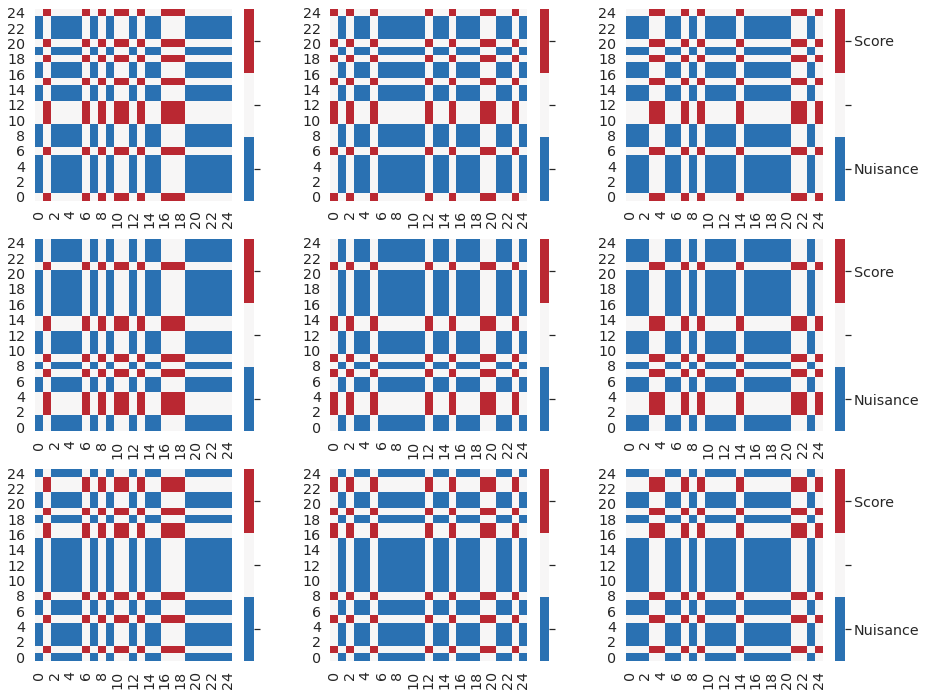

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



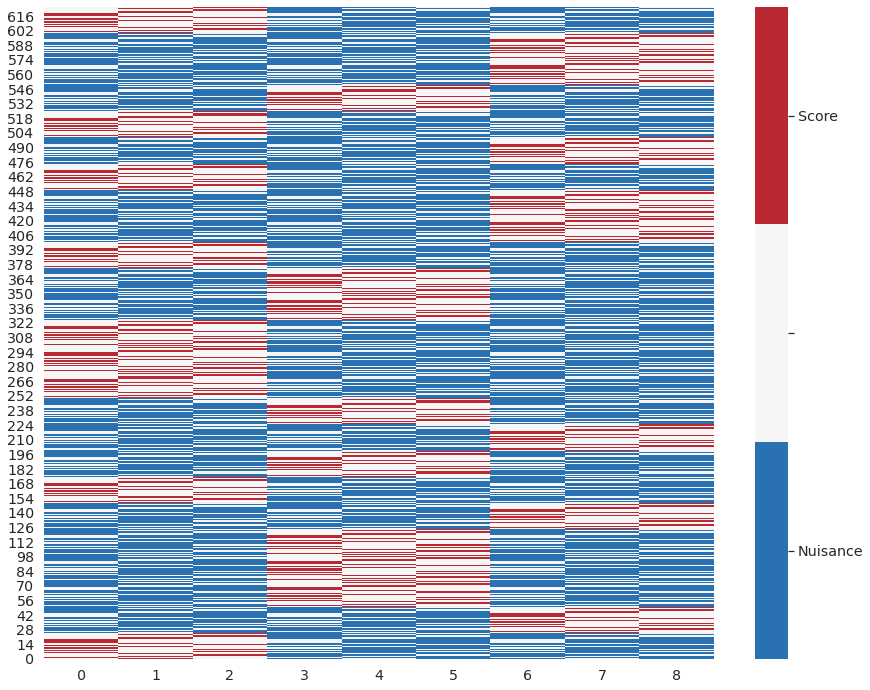

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])